# Twitter

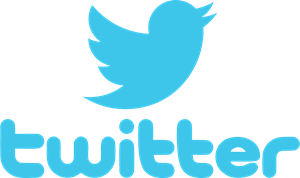

Twitter API allows to fetch live tweets by keyword, or to fetch a 1/6th sample of all twitter traffic.

### Setting up Twitter Credentials

* go to https://apps.twitter.com/
* Apply for a (personal) twitter developer account
* Create a new project
* "Keys and Access Tokens"
* save four keys into `.env` file (or copy `sample.env` to `.env` first)
    * `CONSUMER_KEY` = Consumer Key (API Key)
    * `CONSUMER_SECRET` = Consumer Secret (API Secret)
    * `TWITTER_TOKEN` = Access Token
    * `TWITTER_SECRET` = Access Token Secret

### Getting Started

In [73]:
import os

from dotenv import load_dotenv
load_dotenv()

CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
TWITTER_TOKEN = os.environ['TWITTER_TOKEN']
TWITTER_SECRET = os.environ['TWITTER_SECRET']

In [74]:
import re

import twitter

# create new twitter stream
stream = twitter.TwitterStream(
    timeout=3600,
    heartbeat_timeout=3600,
    auth=twitter.OAuth(TWITTER_TOKEN,
                       TWITTER_SECRET,
                       CONSUMER_KEY,
                       CONSUMER_SECRET))

def get_tweets(terms):
    """
    stream all tweets (within 1/6th quota) indefinitely that contain any of the `terms`.
    
    `statuses.filter` doesn't always return correct matches, so we have to double-check ;)
    """
    # NOTE: using weird syntax instead of '\b' for non-word-boundaries (i.e. starting with '#')
    rex = re.compile(
        r'(?:^|[\W\D]|$)(?:%s)(?:^|[\W\D]|$)' % ('|'.join(re.escape(k) for k in terms),),
        flags=re.I)
    track = ','.join(terms)
    
    for tweet in stream.statuses.filter(track=track):
        text = tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text')
        if tweet.get('lang') == 'en' and rex.search(text):
            yield tweet

### Tweet Filtering

We are looking for all current live tweets that contain the following keywords.
Let's see how long it will take to fetch 10 live tweets?

In [75]:
from itertools import islice

from tqdm import tqdm_notebook

terms = [
    '#BigData',
    '#MachineLearning',
    'machine learning',
    'deep learning',
    'artificial intelligence',
    'data science',
    '#ml',
    '#deeplearning',
    '#datascience',
    '#machinelearning',
    'natural language processing'
]

    
res = tqdm_notebook(get_tweets(terms))
res = list(islice(res, 10))

# Note: figure out how to close stream after use to prevent "Enhance your Calm" error
del stream

### Tweet Structure

A tweet contains a lot of data and metadata:

In [76]:
import json

print(json.dumps(res[0], indent=4))

{
    "created_at": "Sat Oct 12 10:58:00 +0000 2019",
    "id": 1182973687705808896,
    "id_str": "1182973687705808896",
    "text": "An achievable view of artificial intelligence - https://t.co/rCvLnVp781 https://t.co/Q5vmTDcs8E",
    "source": "<a href=\"https://promorepublic.com\" rel=\"nofollow\">PromoRepublic</a>",
    "truncated": false,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_screen_name": null,
    "user": {
        "id": 1934016607,
        "id_str": "1934016607",
        "name": "Network Explosion",
        "screen_name": "networkexplode",
        "location": "Johannesburg",
        "url": "http://www.networkexplosion.co.za",
        "description": "Digital media coaching and hosting of digital media platforms - we make time for you",
        "translator_type": "none",
        "protected": false,
        "verified": false,
        "followers_count": 274,
 

### Matched Tweets

Let's look at some of the tweet texts we have captured:

In [77]:
import json
import pandas as pd
pd.options.display.max_colwidth = 280


def prep_tweets(tweets):
    """
    extract fields of interests from tweets
    """
    for tweet in tweets:
        yield {
            'text': tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text'),
            'author': tweet.get('user', {}).get('screen_name'),
            #'lang': tweet.get('lang'),
            # 'urls': [x.get('expanded_url') or x.get('url') for x in tweet.get('entities', {}).get('urls')]
        }

        
prepped = list(prep_tweets(res))
pd.DataFrame(prepped)

,author,text
0,networkexplode,An achievable view of artificial intelligence - https://t.co/rCvLnVp781 https://t.co/Q5vmTDcs8E
1,JGAvatar1157,RT @agoeskoes: The ecosystem of #Industry40 \n#by @alison_iot\n\n#infographic #machinelearning #IIoT #4IR #DigitalTransformation #Tech #infos…
2,TransitQuote,How to Put Data Science to Work for Your Supply Chain https://t.co/RUJAjSQ1Zf
3,FindNerdJobs,☀ Hiring: #PL/ SQL Developer (F2F required)\n#Austin #BigData #DBA #SQL #techjobs #devjobs\nApply Now &gt;&gt; https://t.co/XfFFPNOjnf https://t.co/1YXjhc6gyj
4,BentleyFranklin,RT @pascal_bornet: Harvard shows how #MachineLearning can be applied to #Architecture design\n https://t.co/SoIrfWcoag\n\n#AI #ML\n@alvinfoo @F…
5,John_ITJobs,"Staff Data Scientist job opening in #Atlanta, GA #techjobs Role Summary: The Staff Data Scientist in Power Digital Data Science &amp; Analytics team will be responsible for delivering machine... - https://t.co/5MrLn82sX3"
6,cortizpr,RT @darshan_h_sheth: New generation of #prosthetics can read mind using #machineLearning and #EMG\n@pascal_bornet @darshan_h_sheth\n@alvinfoo…
7,BigDataBatman,Learn Batman Testing with NoSQL using Cassandra and HBase https://t.co/wr35cGo5Zy #machinelearning #ad
8,DeSaInTeD,Valley Insights Recaps First Year Of Artificial Intelligence Insights - https://t.co/Hn08dGOeHE https://t.co/U1YOD3PU4j dlvrit #AI #ArtificialIntelligence
9,dheeraj1620,"From @F1 to @MotoGP, the adoption of #AI, #ML, #generativedesign and #3Dprinting are transforming #manufacturing in motorsport. Read more from Autodesk’s Brent Pittman in @EurekaMagazine: https://t.co/ln99EFdAoR #AutodeskPartner https://t.co/ArerRAWn4P"


### Hashtags

Find which hashtags occur most frequently in our matched tweets

In [80]:
import gzip
import json
from collections import Counter
import pandas as pd


def get_tweets_from_file():
    """
    load matched tweets from file
    """
    with gzip.open('data/machine_learning-2018-09-26.jl.gz', 'rt') as fhandle:
        for line in fhandle:
            yield json.loads(line)

            
def hashtags(elt):
    """
    get all hashtags from deep within tweet (extended_tweet, retweets, etc.)
    """
    if isinstance(elt, list):
        for x in elt:
            yield from hashtags(x)
    elif isinstance(elt, dict):
        if 'hashtags' in elt:
            yield [x.get('text').lower() for x in elt['hashtags']]
        for v in elt.values():
            yield from hashtags(v)
            
            
tweets = list(islice(get_tweets_from_file(), 1000))
hashtags_per_tweet = [sum(hashtags(tweet), []) for tweet in tweets]
all_hashtags = sum(hashtags_per_tweet, []) 
ctr = Counter(all_hashtags)
pd.DataFrame(ctr.most_common(30))

,0,1
0,ai,771
1,bigdata,555
2,machinelearning,532
3,iot,344
4,datascience,339
5,deeplearning,294
6,ml,198
7,artificialintelligence,169
8,fintech,165
9,blockchain,138


### Leveraging Twitter Data

Based on the Twitter data we can generate many potential use cases:

* [Matched Tweets per Day](https://fluquid.com:5000/twitter)
* [DeepMoji](https://github.com/bfelbo/DeepMoji)
* Find job offerings
* Build a social graph of tweeters
* Engage with trending tweets, conversations in your niche
* Build live language models, sentiment analysis i.e. for elections
* etc.

In [92]:
terms = [
    '😂', '😭', '😍', '❤️', '👉', '💜', '💕', '😊', '🤔', '🙏', '😀', '😎', '🎉', '😊', '💩'
]

stream = twitter.TwitterStream(
    timeout=120,
    heartbeat_timeout=3600,
    auth=twitter.OAuth(TWITTER_TOKEN,
                       TWITTER_SECRET,
                       CONSUMER_KEY,
                       CONSUMER_SECRET))

res = tqdm_notebook(get_tweets(terms))
res = list(islice(res, 100))

# Note: figure out how to close stream after use to prevent "Enhance your Calm" error
del stream

In [93]:
import re

from emoji.core import get_emoji_regexp

RE_EMOJI = get_emoji_regexp()

def prep_tweets(tweets):
    """
    extract fields of interests from tweets
    """
    emojis = []
    for tweet in tweets:
        text = tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text')
        yield {
            'text': RE_EMOJI.sub('', text),
            'emojis': list(set(RE_EMOJI.findall(text)))
        }
        
prepped = list(prep_tweets(res))
pd.DataFrame(prepped)

,emojis,text
0,[😭],RT @armntingzs: This bitch is my inspiration https://t.co/WRXzyg5GKe
1,[🤔],"RT @rgpoulussen: There's a ""German"" telling all what the plan is. https://t.co/YCxoJXM3SA"
2,[😭],RT @jihoonfullsun: MUST U MAKE ME CRY https://t.co/pNJFjRfqql
3,[😊],@amalia122015 @HeyRhett Maam you can pick 1 person. Send it to that person. thank you for being honest. God bless. #800cc
4,[😂],@cidibrileg @INEOS159 @EliudKipchoge Retweeting your own tweet https://t.co/ZckPd3q6yV
5,[😭],RT @koalatreat: I found the cutest Tik Tok thread and the last one makes it even cuter I’m sobbing https://t.co/Rkewexi6oc
6,[💕],"Beautiful, dramatic image"
7,[💜],happy 25th
8,[😂],@LILIPRATICUS Indeed. And probably the one of the richest ones
9,[💜],RT @misayeon: Sana is the ending fairy for TWICE's last goodbye stage today! \n#TWICE #FeelSpecial https://t.co/z5cQnf1WMg


In [94]:
from collections import Counter
together = sum([p['emojis'] for p in prepped], [])
Counter(together).most_common(15)


[('😭', 27),
 ('😂', 24),
 ('😍', 16),
 ('❤', 10),
 ('😊', 8),
 ('💕', 7),
 ('🔥', 6),
 ('💜', 5),
 ('🙏', 5),
 ('🤔', 3),
 ('♥', 3),
 ('💪', 3),
 ('😎', 3),
 ('\U0001f929', 3),
 ('👉', 2)]